In [1]:
import pandas as pd
import numpy as np

## Preprocessamento dos dados

In [2]:
# Load the dataset after the exploratory data analysis
# challenge_set_updated = pd.read_csv("./data/challenge_set_updated_v7.csv")
# challenge_set_updated = pd.read_csv("./data/challenge_set_updated_v12.csv")
# challenge_set_updated = pd.read_csv("./data/challenge_set_updated_v13.csv")
# challenge_set_updated = pd.read_csv("./data/challenge_set_updated_v16.csv")
challenge_set_updated = pd.read_csv("./data/challenge_set_updated_v18.csv")
submission_set = pd.read_csv("./data/final_submission_set.csv")
# submission_set_updated = pd.read_csv("./data/submission_set_updated_v7.csv")
# submission_set_updated = pd.read_csv("./data/submission_set_updated_v12.csv")
# submission_set_updated = pd.read_csv("./data/submission_set_updated_v13.csv")
# submission_set_updated = pd.read_csv("./data/submission_set_updated_v16.csv")
submission_set_updated = pd.read_csv("./data/submission_set_updated_v18.csv")

# If necessary change this part to test the model before the training process
df = challenge_set_updated.iloc[:,:]
# df = challenge_set_updated.sample(frac=0.001)

# Separating features and target variable
X = df.drop('tow', axis=1)
y = df['tow']

df.head()

,adep,ades,aircraft_type,wtc,airline,taxiout_time,flown_distance,track_variation_ARR_100,track_variation_DEP_40,track_variation_ENR,...,Latitude_ades,Longitude_ades,Altitude_ades,actual_distance,altitude_difference,bearing,elevation_gradient,adep_geo_cluster,ades_geo_cluster,tow
0,EGLL,EICK,A320,M,a73f82288988b79be490c6322f4c32ed,18.0,321,124.812764,39.704139,18.449496,...,51.843,-8.492,154,555.164898,129,277.346455,0.232363,13,0,54748.000000
1,LEBL,KMIA,B772,H,5543e4dc327359ffaf5b9c0e6faaf0e1,13.0,4193,178.548749,0.300762,76.738006,...,25.793,-80.291,3,7544.863035,-1,285.530704,-0.000133,19,12,185441.000000
2,ESSA,KORD,A333,H,8be5c854fd664bcb97fb543339f74770,15.0,3770,178.790456,2.134917,87.653499,...,41.979,-87.904,204,6855.624802,166,305.643136,0.024214,8,15,230396.000000
3,LSZH,KPHL,B788,H,5543e4dc327359ffaf5b9c0e6faaf0e1,11.0,3607,0.208347,4.285337,101.790624,...,39.872,-75.241,12,6459.885397,-420,296.005451,-0.065017,2,1,157615.000000
4,EIDW,EGLL,A21N,M,a73f82288988b79be490c6322f4c32ed,14.0,305,160.264693,174.928513,47.213622,...,51.477,-0.461,25,448.923048,-49,116.445141,-0.109150,0,13,70318.447226


## Modelo (com pre-processamento auto)

In [3]:
# cat_names = ['adep',
#              'ades',
#              'aircraft_type', 
#              'wtc', 
#              'airline',
#              'offblock_hour',
#              'offblock_minute', 
#              'offblock_day_of_week',
#              'offblock_month',
#              'offblock_week_of_year', 
#              'offblock_season', 
#              'arrival_hour',
#              'arrival_minute',
#              'is_offblock_weekend',
#              'is_offblock_rush_hour',
#              'flight_duration_category',                       
#              'adep_region', 
#              'ades_region', 
#              'same_country_flight',
#              'same_region_flight',                        
#              'flight_direction',
#              'is_intercontinental',
#              'temperature_bins_ARR',
#              'humidity_bins_DEP',
#              'Physical_Class_Engine',
#              'Num_Engines',
#              'Main_Gear_Config',
#              'FAA_Weight',
#              'adep_geo_cluster',
#              'ades_geo_cluster']

cat_names = ['adep', 
            'ades', 
            'aircraft_type', 
            'wtc', 
            'airline',
            'offblock_hour',
            'offblock_minute', 
            'offblock_day_of_week',
            'offblock_weekday_name',
            'offblock_month',
            'offblock_week_of_year', 
            'offblock_season', 
            'arrival_hour',
            'arrival_minute',
            'arrival_season',
            'arrival_weekday_name',
            'is_offblock_weekend',
            'is_offblock_rush_hour',
            'flight_duration_category',                       
            'adep_region', 
            'ades_region', 
            'same_country_flight',
            'same_region_flight',                        
            'flight_direction',
            'is_intercontinental',
            'Manufacturer',
            'Model_FAA',
            'Physical_Class_Engine',
            'FAA_Weight',
            'adep_geo_cluster',
            'ades_geo_cluster']

In [4]:
# null_value_stats = df.isnull().sum(axis=0)
pd.set_option('display.max_rows', None)

print(df.isna().mean())

pd.reset_option('display.max_rows')

adep                                0.000000
ades                                0.000000
aircraft_type                       0.000000
wtc                                 0.000000
airline                             0.000000
taxiout_time                        0.000000
flown_distance                      0.000000
track_variation_ARR_100             0.041169
track_variation_DEP_40              0.031424
track_variation_ENR                 0.000688
average_vertical_rate_ARR_100       0.041175
average_vertical_rate_DEP_40        0.031427
average_vertical_rate_ENR           0.000694
average_airspeed_ARR_100            0.041169
average_airspeed_DEP_40             0.031424
average_airspeed_ENR                0.000688
groundspeed_ARR_100                 0.041169
groundspeed_DEP_40                  0.031424
groundspeed_ENR                     0.000688
wind_distance_ARR_100               0.000000
wind_distance_DEP_40                0.000000
wind_distance_ENR                   0.000000
average_te

In [5]:
# threshold = 0.4
# df = df.dropna(thresh=int((1 - threshold) * len(df)), axis=1)

In [6]:
# Imputation of NaNs
columns_with_nan = df.isna().any()
print(columns_with_nan)
for col in df.columns[columns_with_nan]:
    df.loc[:, col] = df.fillna(df[col].median())

adep                  False
ades                  False
aircraft_type         False
wtc                   False
airline               False
                      ...  
bearing               False
elevation_gradient    False
adep_geo_cluster      False
ades_geo_cluster      False
tow                   False
Length: 215, dtype: bool


In [7]:
X = df.drop('tow', axis=1)
y = df.tow

['tas_1', 'sqrd_tas_1', 'adep_height_1', 'altitude_1', 'altitude_2', 'altitude_3', 'altitude_4', 'altitude_5', 'altitude_6', 'altitude_7', 'altitude_8', 'altitude_9', 'altitude_10', 'offblock_month', 'arrival_day_of_year', 'arrival_month', 'arrival_week_of_year', 'arrival_quarter', 'offblock_to_arrival_duration', 'normalized_taxi_ratio', 'flight_time_excl_taxi', 'groundspeed_flown_distance_ENR', 'humidity_temperature_ARR', 'humidity_temperature_DEP', 'humidity_temperature_ENR', 'vertical_rate_airspeed_DEP', 'vertical_rate_airspeed_ENR', 'vertical_rate_airspeed_ratio_ARR', 'MALW_kg', 'mzfw_kg', 'max_fuel_l', 'cargo_capacity', 'oew_kg', 'seats_max', 'actual_distance']


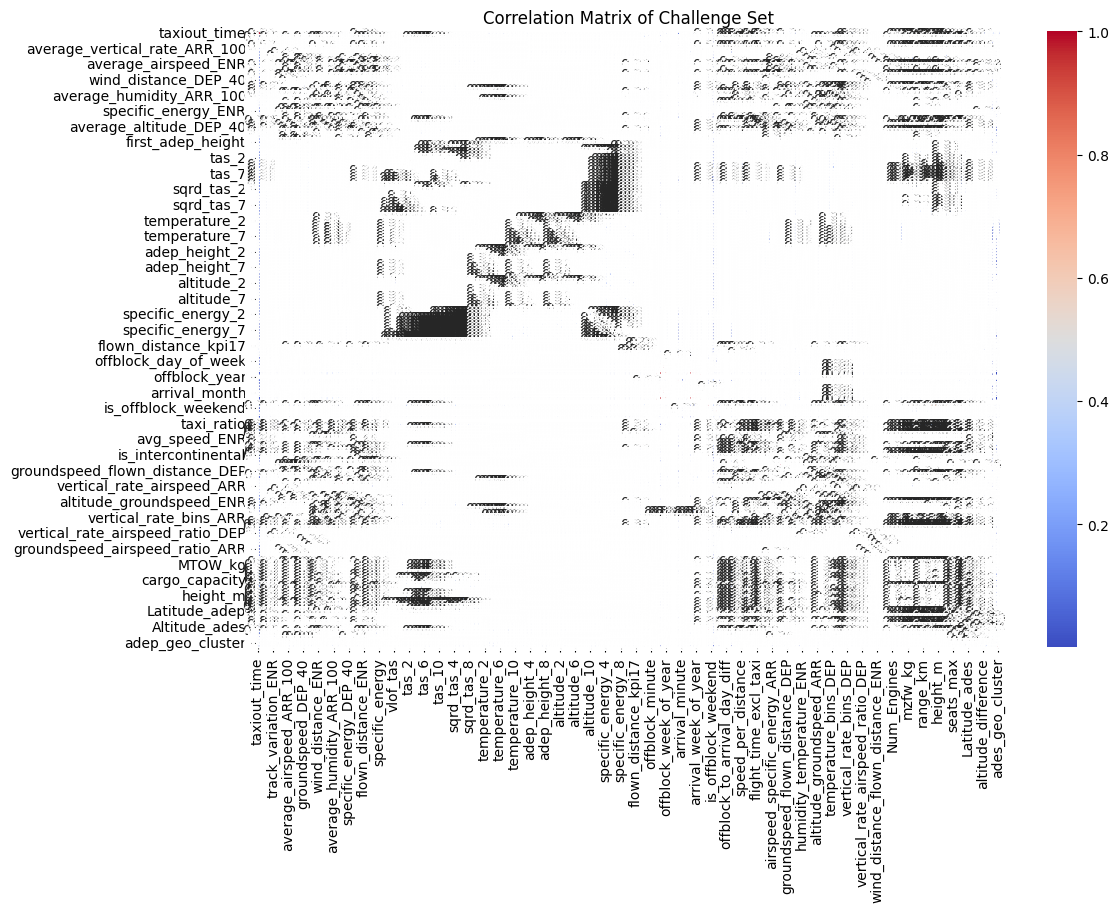

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Create correlation matrix
corr_matrix = X.corr(numeric_only=True).abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.98
to_drop = [column for column in upper.columns if any(upper[column] > 0.98)]
print(to_drop)

# corr_matrix['offblock_week_of_year'].sort_values(ascending=False).head()
# corr_matrix['offblock_to_arrival_duration'].sort_values(ascending=False).head()
# corr_matrix['normalized_taxi_ratio'].sort_values(ascending=False).head()
# corr_matrix['MALW_kg'].sort_values(ascending=False).head()

# Plotting the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Challenge Set')
plt.show()

# # Drop features 
# X.drop(to_drop, axis=1, inplace=True)

In [23]:
print(X.iloc[:, 58])
print('Sum of elements as float: ', X.iloc[:, 58].sum())
print(X.iloc[:, 59])
print('Sum of elements as float: ', X.iloc[:, 59].sum())

0         4933.494791
1         6564.008513
2         6800.330934
3         8587.456216
4         5615.193239
             ...     
369008    7343.016018
369009    7492.560434
369010    2250.199208
369011    6901.780501
369012    6244.583561
Name: sqrd_tas_5, Length: 369013, dtype: float64
Sum of elements as float:  2290249585.6706667
0         4745.383699
1         7606.561032
2         6772.663859
3         8590.572421
4         5450.705670
             ...     
369008    7343.090120
369009    6347.311165
369010    2250.192318
369011    6915.069105
369012    6227.775302
Name: sqrd_tas_6, Length: 369013, dtype: float64
Sum of elements as float:  2290033605.0436783


In [24]:
# Converting this categorical variable to int because Catboost wasn't liking it as float
X['temperature_bins_ARR'] = X['temperature_bins_ARR'].astype(int)
X['humidity_bins_DEP'] = X['humidity_bins_DEP'].astype(int)

In [25]:
print(X.iloc[:, 58])

0         4933.494791
1         6564.008513
2         6800.330934
3         8587.456216
4         5615.193239
             ...     
369008    7343.016018
369009    7492.560434
369010    2250.199208
369011    6901.780501
369012    6244.583561
Name: sqrd_tas_5, Length: 369013, dtype: float64


In [28]:
from catboost import CatBoostRegressor, Pool, metrics
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

not_dropped_cat_names = [x for x in cat_names if x not in to_drop]

params = {
    'learning_rate': 0.05, 
    'reg_lambda': 69.07051080443502, 
    # 'subsample': 0.9831691718361609, 
    'random_strength': 16.348436502754343, 
    'depth': 11, 
    # 'colsample_bylevel': 0.9434202103659302, 
    'min_data_in_leaf': 2, 
    'leaf_estimation_iterations': 7
    # 'reg_lambda': 15.865685490104017, 
    # 'random_strength': 33.58229075926253, 
    # 'depth': 11, 
    # 'min_data_in_leaf': 3, 
    # 'leaf_estimation_iterations': 15
}
train_pool = Pool(X_train, y_train, cat_features=not_dropped_cat_names)
val_pool = Pool(X_val, y_val, cat_features=not_dropped_cat_names)

model = CatBoostRegressor(
    iterations=5000,
    objective=metrics.RMSE(),
    eval_metric=metrics.RMSE(),
    random_seed=42,
    verbose=False,
    task_type='GPU',
    use_best_model=True,
    od_type='Iter',
    od_wait=20,
    **params,
)

In [29]:
result = model.select_features(
    train_pool, eval_set=val_pool,
    features_for_select=X_train.columns.tolist(),
    num_features_to_select=40,
    steps=5,
    plot=True,
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Step #1 out of 5


KeyboardInterrupt: 

In [ ]:
print(result['eliminated_features_names'])

In [ ]:
X.drop(['wind_distance_ARR_100', 'average_airspeed_ARR_100', 'track_variation_ARR_100', 
        'is_offblock_weekend', 'Num_Engines', 'flown_distance_ARR_100', 'average_humidity_ARR_100',
        'average_temperature_ARR_100', 'wind_distance_DEP_100', 'arrival_minute', 'track_variation_ENR',
        'groundspeed_ARR_100', 'average_vertical_rate_ARR_100', 'taxiout_time', 'track_variation_DEP_100',
        'average_airspeed_DEP_100', 'offblock_minute', 'average_airspeed_ENR', 'specific_energy_ENR',
        'taxi_ratio', 'average_humidity_DEP_100', 'specific_energy_ARR_100', 'is_offblock_rush_hour',
        'wind_distance_ENR', 'groundspeed_ENR', 'altitude_difference', 'average_vertical_rate_ENR',
        'bearing', 'Altitude_ades'], axis=1, inplace=True)

In [ ]:
print(result['eliminated_features_names'])
X.drop(result['eliminated_features_names'], axis=1, inplace=True)

In [ ]:
eliminated = ['wind_distance_ARR_100', 'average_airspeed_ARR_100', 'track_variation_ARR_100', 
        'is_offblock_weekend', 'Num_Engines', 'flown_distance_ARR_100', 'average_humidity_ARR_100',
        'average_temperature_ARR_100', 'wind_distance_DEP_100', 'arrival_minute', 'track_variation_ENR',
        'groundspeed_ARR_100', 'average_vertical_rate_ARR_100', 'taxiout_time', 'track_variation_DEP_100',
        'average_airspeed_DEP_100', 'offblock_minute', 'average_airspeed_ENR', 'specific_energy_ENR',
        'taxi_ratio', 'average_humidity_DEP_100', 'specific_energy_ARR_100', 'is_offblock_rush_hour',
        'wind_distance_ENR', 'groundspeed_ENR', 'altitude_difference', 'average_vertical_rate_ENR',
        'bearing', 'Altitude_ades']
selected_cat_names = [x for x in cat_names if x not in eliminated]

# print(selected_cat_names)
# print(result['eliminated_features_names'])

In [9]:
from catboost import CatBoostRegressor, Pool, metrics
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

params = {
    'learning_rate': 0.01, 
    'reg_lambda': 0.05357182104973179, 
    'random_strength': 20.10951792232919, 
    'depth': 9, 
    'min_data_in_leaf': 11, 
    'leaf_estimation_iterations': 12
    # 'learning_rate': 0.01, 
    # 'reg_lambda': 69.07051080443502, 
    # # 'subsample': 0.9831691718361609, 
    # 'random_strength': 16.348436502754343, 
    # 'depth': 11, 
    # # 'colsample_bylevel': 0.9434202103659302, 
    # 'min_data_in_leaf': 2, 
    # 'leaf_estimation_iterations': 7
    # 'reg_lambda': 15.865685490104017, 
    # 'random_strength': 33.58229075926253, 
    # 'depth': 11, 
    # 'min_data_in_leaf': 3, 
    # 'leaf_estimation_iterations': 15
}
not_dropped_cat_names = [x for x in cat_names if x not in to_drop]

train_pool = Pool(X_train, y_train, cat_features=cat_names)
val_pool = Pool(X_val, y_val, cat_features=cat_names)
# train_pool = Pool(X_train, y_train, cat_features=not_dropped_cat_names)
# val_pool = Pool(X_val, y_val, cat_features=not_dropped_cat_names)
# train_pool = Pool(X_train, y_train, cat_features=selected_cat_names)
# val_pool = Pool(X_val, y_val, cat_features=selected_cat_names)

model = CatBoostRegressor(
    iterations=50000,
    objective=metrics.RMSE(),
    eval_metric=metrics.RMSE(),
    random_seed=42,
    verbose=False,
    task_type='GPU',
    use_best_model=True,
    od_type='Iter',
    od_wait=50,
    **params,
)

In [8]:
model.fit(
    train_pool, eval_set=val_pool,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [10]:
model.save_model('catboost_train.cbm', 'cbm')

In [10]:
best_iteration = model.get_best_iteration()
model = CatBoostRegressor(
    iterations=47805,#best_iteration
    objective=metrics.RMSE(),
    random_seed=42,
    verbose=False,
    task_type='GPU',
    **params,
)
model.fit(
    X, y, 
    cat_features=cat_names,
    # cat_features=not_dropped_cat_names,
    # cat_features=selected_cat_names, 
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [22]:
model.save_model('catboost_all.cbm', 'cbm')

In [9]:
feature_importances = model.get_feature_importance(train_pool)
feature_names = X_train.columns
for score, name in sorted(zip(feature_importances, feature_names), reverse=True):
    print('{}: {}'.format(name, score))

FAA_Weight: 12.96497029028256
stall_vel_knots: 8.252459724084824
height_m: 8.045703167595672
oew_kg: 7.4387481323152125
seats_min: 7.233194228443552
airline: 7.190420717828868
wtc: 5.177356644224019
seats_max: 4.557388439944147
length_m: 4.490955927181785
Manufacturer: 4.458850826912884
tas_knots: 3.4462729512133516
MALW_kg: 2.2538950833168894
seats_typ: 1.6921116693867346
flight_duration_category: 1.4841810756545235
range_km: 1.3789849694496763
aircraft_type: 1.211283243206808
wingspan_m: 1.135205173289378
max_fuel_l: 1.0631964821386226
speed_per_distance: 0.9295344020121745
average_altitude_ENR: 0.8247049321043153
flown_distance: 0.8168300220041187
Model_FAA: 0.7740963726273085
offblock_to_arrival_duration: 0.7671573307687926
actual_distance: 0.7248104700814794
mzfw_kg: 0.6560546943866191
MTOW_kg: 0.5727545178202235
average_vertical_rate_DEP_40: 0.5421162553762351
Approach_Speed_knot: 0.5018280584964564
flown_distance_bins: 0.3838024228215366
cargo_capacity: 0.381306726213922
flight_

C:\Users\rudog\AppData\Local\Temp\ipykernel_14800\4133665165.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = feature_im_df[:20], x='importance', y='feature', palette="viridis")


<Figure size 1000x600 with 0 Axes>

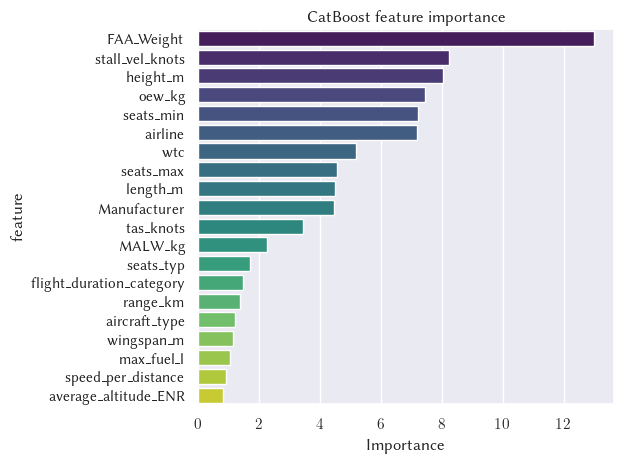

In [45]:
# Get feature importances
# feature_importances = model.get_feature_importance()
import matplotlib

feature_im_df = pd.DataFrame({
    "feature": X.columns,
    "importance": feature_importances
})

feature_im_df = feature_im_df.sort_values(by="importance", ascending=False)

sns.set(rc={'text.usetex' : True, 'text.latex.preamble': '\\usepackage{libertine}'})
plt.figure(figsize=(10, 6))
plt.figure()
sns.barplot(data = feature_im_df[:20], x='importance', y='feature', palette="viridis")

plt.title("CatBoost feature importance")
plt.xlabel("Importance")
plt.ylabel("feature")
plt.tight_layout()
plt.savefig('catboost_feature_importance.pdf', bbox_inches='tight')
plt.show()

In [ ]:
trajectory_features = [
    'track_variation_ARR_100',
    'track_variation_DEP_100',
    'track_variation_ENR',
    'average_vertical_rate_ARR_100',
    'average_vertical_rate_DEP_100',
    'average_vertical_rate_ENR',
    'average_airspeed_ARR_100',
    'average_airspeed_DEP_100'
    'average_airspeed_ENR',
    'groundspeed_ARR_100',
    'groundspeed_DEP_100',
    'groundspeed_ENR',
    'wind_distance_ARR_100',
    'wind_distance_DEP_100',
    'wind_distance_ENR',
    'average_temperature_ARR_100',
    'average_temperature_DEP_100',
    'average_temperature_ENR',
    'average_humidity_ARR_100',
    'average_humidity_DEP_100',
    'average_humidity_ENR',
    'specific_energy_ARR_100',
    'specific_energy_DEP_100',
    'specific_energy_ENR',
    'flown_distance_ARR_100',
    'flown_distance_DEP_100',
    'flown_distance_ENR',
    'specific_energy',
]

for score, name in sorted(zip(feature_importances, feature_names), reverse=True):
    if name in trajectory_features:
        print('{}: {}'.format(name, score))

## Training on GPU

In [ ]:
params = {
    'objective': 'RMSE',
    'iterations': 500,
    'learning_rate': 0.1,
    'eval_metric': metrics.RMSE(),
    'random_seed': 42,
    'logging_level': 'Silent',
    'use_best_model': False,
    'task_type': 'GPU',
}
train_pool = Pool(X_train, y_train, cat_features=cat_names)
val_pool = Pool(X_val, y_val, cat_features=cat_names)

In [ ]:
%%time
from sklearn.metrics import mean_squared_error

model = CatBoostRegressor(**params)
model.fit(train_pool, eval_set=val_pool)

best_model_params = params.copy()
best_model_params.update({
    'use_best_model': True
})
best_model = CatBoostRegressor(**best_model_params)
best_model.fit(train_pool, eval_set=val_pool)

print('Simple model validation MSE: {:.4}'.format(
    root_mean_squared_error(y_val, model.predict(X_val))
))
print('')

print('Best model validation MSE: {:.4}'.format(
    root_mean_squared_error(y_val, best_model.predict(X_val))
))

## Features Importances

In [ ]:
model = CatBoostRegressor(**params).fit(train_pool)
feature_importances = model.get_feature_importance(train_pool)
feature_names = X_train.columns
for score, name in sorted(zip(feature_importances, feature_names), reverse=True):
    print('{}: {}'.format(name, score))

## Hyperparameter Tunning

In [ ]:
!pip install optuna

In [ ]:
import optuna

def objective(trial):
    # Taken from: https://deepnote.com/app/svpino/Tuning-Hyperparameters-with-Optuna-ea1a123d-8d2f-4e20-8f22-95f07470d557
    params = {
        'learning_rate' : trial.suggest_float('learning_rate', 0.01, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-5, 100),
        # 'subsample': trial.suggest_float('subsample', 0, 1),
        'random_strength': trial.suggest_float('random_strength', 10, 50),
        'depth': trial.suggest_int('depth', 1, 15),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 30),
        'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations', 1, 15),
    }
    
    model = CatBoostRegressor(
        iterations=1000,
        eval_metric=metrics.RMSE(),
        random_seed=42,
        verbose=False,
        objective=metrics.RMSE(),
        task_type='GPU', # training on GPU
        use_best_model=True,
        od_type='Iter',
        od_wait=20,
        **params,
    )

    cv_data = cv(
        train_pool,
        model.get_params(),
        logging_level='Silent',
    )
    best_rmse = np.min(cv_data['test-RMSE-mean'])

    return best_rmse

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Display the best hyperparameters found
print(f"Best trial: {study.best_trial.params}")

# Train the final model with the best parameters
best_params = study.best_trial.params
best_model = CatBoostRegressor(
    iterations=5000,
    eval_metric=metrics.RMSE(),
    random_seed=42,
    logging_level='Silent',
    objective=metrics.RMSE(),
    task_type='GPU', # training on GPU
    use_best_model=True,
    od_type='Iter',
    od_wait=20,
    **best_params,
)

# Train the model with early stopping
best_model.fit(train_pool, eval_set=val_pool)

In [ ]:
model = CatBoostRegressor(
    l2_leaf_reg=int(best['l2_leaf_reg']),
    learning_rate=best['learning_rate'],
    iterations=3000,
    eval_metric=metrics.RMSE(),
    random_seed=42,
    verbose=False,
    objective=metrics.RMSE(),
    task_type='GPU',
    use_best_model=True,
)
cv_data = cv(Pool(X, y, cat_features=cat_names), model.get_params(), plot=True)

In [ ]:
print('RMSE score: {}'.format(np.min(cv_data['test-RMSE-mean'])))

In [ ]:
model.fit(train_pool, eval_set=val_pool)

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 2))
preds_val = model.predict(X_val)
diff_val = preds_val - y_val
plt.hist(diff_val, bins=200)
diff_val.mean(), diff_val.std()

In [ ]:
print('Model validation RMSE: {:.4}'.format(
    root_mean_squared_error(y_val * std + mean, preds_val * std + mean)
))

## Submissão

In [45]:
df_test = pd.read_csv("./data/submission_set_updated_v18.csv")
df_test.head()

,adep,ades,aircraft_type,wtc,airline,taxiout_time,flown_distance,track_variation_ARR_100,track_variation_DEP_40,track_variation_ENR,...,Latitude_ades,Longitude_ades,Altitude_ades,actual_distance,altitude_difference,bearing,elevation_gradient,adep_geo_cluster,ades_geo_cluster,tow
0,LTFJ,LFLL,B738,M,6351ec1b849adacc0cbb3b1313d8d39b,15.0,1122,95.626012,61.832877,110.627438,...,45.726,5.091,251,2022.915548,-61,293.477205,-0.030154,11,17,NaN
1,EBBR,KJFK,A333,H,bdeeef3a675587d530de70a25d7118d2,15.0,3205,101.189988,65.739142,93.558319,...,40.640,-73.779,4,5886.430370,-53,291.395141,-0.009004,6,1,NaN
2,KMIA,EGLL,B77W,H,5543e4dc327359ffaf5b9c0e6faaf0e1,10.0,3965,1.711789,74.068356,27.218391,...,51.477,-0.461,25,7108.920003,22,43.036806,0.003095,12,13,NaN
3,EBBR,LEAL,B738,M,f53c55b5cf0cbb3be755bf50df6fa52d,9.0,802,101.738231,51.771476,20.637128,...,38.282,-0.558,44,1458.405355,-13,197.753476,-0.008914,6,19,NaN
4,LSZH,LFPG,BCS3,M,2d5def0a5a844b343ba1b7cc9cb28fa9,11.0,292,68.791836,68.987429,52.210743,...,49.013,2.550,120,476.291487,-312,293.398537,-0.655061,2,6,NaN


In [46]:
X_test = df_test.drop('tow', axis=1)

In [47]:
# X_test.drop(to_drop, axis=1, inplace=True)
# X_test.drop(eliminated, axis=1, inplace=True)
# X_test.drop(['offblock_to_arrival_duration', 'normalized_taxi_ratio', 'MALW_kg'], axis=1, inplace=True)

In [48]:
y_pred = model.predict(X_test)
y_test = y_pred

In [49]:
y_test

array([ 69471.34081072, 213694.39880119, 222960.98572968, ...,
       197915.81333156,  41448.74984843,  63622.57909623])

In [50]:
dft0 = pd.read_csv('./data/final_submission_set.csv')
print(dft0)

        flight_id        date                          callsign  adep  \
0       248753821  2022-01-01  3b3de0f3ad0ee192513995c02f7bf7cf  LTFJ   
1       248753822  2022-01-01  e06dd03d4a879ca37d9e18c1bd7cad16  EBBR   
2       248754498  2022-01-01  2d3b1c962c78c4ebeef11bcd51b9e94c  KMIA   
3       248763650  2022-01-01  35f7721f68bf85128195547ae38b0f04  EBBR   
4       248763651  2022-01-01  eb56918bee9bc5204624186b9bcc4391  LSZH   
...           ...         ...                               ...   ...   
158144  258068876  2022-12-31  c9fca302ca2e28acab0eb0bb1b46f11b  LTFM   
158145  258064675  2022-12-31  00f96ad0e382476649574ba044c764fc  EHAM   
158146  258065436  2022-12-31  87c552b7f6d9bbd16a66e95df761c7f2  LEBL   
158147  258058138  2022-12-31  2cd57e434494606c965bac87c024bda2  LIPE   
158148  258058370  2022-12-31  5f0c222c7f7ceff3fbe75c854cce74c9  UBBB   

                     name_adep country_code_adep  ades  \
0       Istanbul Sabiha Gokcen                TR  LFLL   
1      

In [51]:
dft0 = pd.read_csv('./data/final_submission_set.csv')
dft0['tow'] = y_test
dft0[['flight_id', 'tow']].to_csv('catboost.csv', index=False)

In [37]:
dft0 = pd.read_csv('./data/final_submission_set.csv')
dft0['tow'] = y_test
dft0[['flight_id', 'tow']].to_csv('catboost.csv', index=False)

In [38]:
!head catboost.csv

'head' nÆo ‚ reconhecido como um comando interno
ou externo, um programa oper vel ou um arquivo em lotes.


In [52]:
print((submission_dataset['aircraft_type'] == dft0['aircraft_type']).sum())

158149


In [53]:
submission_dataset = df_test
submission_dataset['tow'] = y_pred
# submission_dataset.head()
pd.set_option('display.max_rows', None)
# print(submission_dataset.T)
pd.reset_option('display.max_rows')
print((submission_dataset['tow'] > submission_dataset['MTOW_kg']).sum())
mask = (submission_dataset['tow'] > submission_dataset['MTOW_kg'])
submission_dataset.loc[mask, 'tow'] = submission_dataset.loc[mask, 'MTOW_kg']
print((submission_dataset['tow'] > submission_dataset['MTOW_kg']).sum())

97
0


In [54]:
dft0 = pd.read_csv('./data/final_submission_set.csv')
dft0['tow'] = submission_dataset['tow']
dft0[['flight_id', 'tow']].to_csv('catboost_sat.csv', index=False)